In [73]:
import tensorflow as tf

import matplotlib.pyplot as plt
import numpy as np

from sde.sde_learning_network import \
    (
        SDEIdentification,
        ModelBuilder,
        SDEApproximationNetwork,
    )

from sde.experiment_reports import \
(
    sample_data,
    plot_results_functions,
    generate_results,
    plot_results_1d,
    plot_results_1d_generated,
    plot_distribution
)
from sde.thesis_experiments import \
(
    loadSIRInfo,
    loadSIRInfo1D
)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [56]:
# notebook parameters
random_seed = 1
step_size = 1e-1  # 5e-2 # step size
n_pts = 5000        # number of points

n_layers = 5
n_dim_per_layer = 25

n_dimensions = 1

ACTIVATIONS = tf.nn.tanh
VALIDATION_SPLIT = .2
BATCH_SIZE = 512
N_EPOCHS = 40

# only diagonal diffusivity matrix (does not matter since we are in 1D)
diffusivity_type = "diagonal"

tf.random.set_seed(random_seed)

In [57]:
# define the neural network model we will use for identification
encoder = ModelBuilder.define_gaussian_process(
                                        n_input_dimensions=n_dimensions,
                                        n_output_dimensions=n_dimensions,
                                        n_layers=n_layers,
                                        n_dim_per_layer=n_dim_per_layer,
                                        name="GP",
                                        activation=ACTIVATIONS,
                                        diffusivity_type=diffusivity_type)
encoder.summary()

model = SDEApproximationNetwork(sde_model=encoder, method="euler")
model.compile(optimizer=tf.keras.optimizers.Adamax())

sde_i = SDEIdentification(model=model)

Model: "GP_gaussian_process"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 GP_inputs (InputLayer)         [(None, 1)]          0           []                               
                                                                                                  
 GP_mean_hidden_0 (Dense)       (None, 25)           50          ['GP_inputs[0][0]']              
                                                                                                  
 GP_std_hidden_0 (Dense)        (None, 25)           50          ['GP_inputs[0][0]']              
                                                                                                  
 GP_mean_hidden_1 (Dense)       (None, 25)           650         ['GP_mean_hidden_0[0][0]']       
                                                                                

In [58]:
x_data,y_data,x_data_test,y_data_test = loadSIRInfo1D()
step_sizes = np.zeros((x_data.shape[0],)) + step_size

### Train 4000, Validate 1000, Test 1000 data points.

training for 40 epochs with 4000 data points, validating with 1000
The average loss for epoch 39 is -1.1396154288 

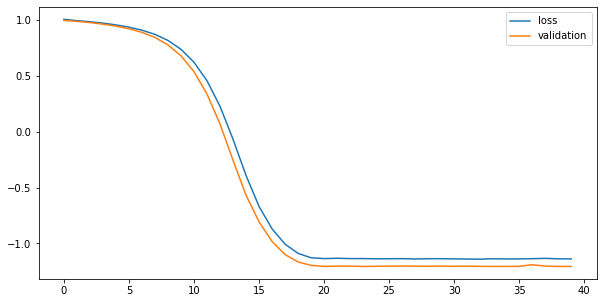

In [59]:
hist = sde_i.train_model(x_data, y_data, step_size=step_sizes,
                         validation_split=VALIDATION_SPLIT, n_epochs=N_EPOCHS, batch_size = BATCH_SIZE)

fig, hist_axes = plt.subplots(1, 1, figsize=(10, 5))
hist_axes.clear()
hist_axes.plot(hist.history["loss"], label='loss')
hist_axes.plot(hist.history["val_loss"], label='validation')
hist_axes.legend()

# If start is 0.01, graph of generated results

(0.0, 10.0)

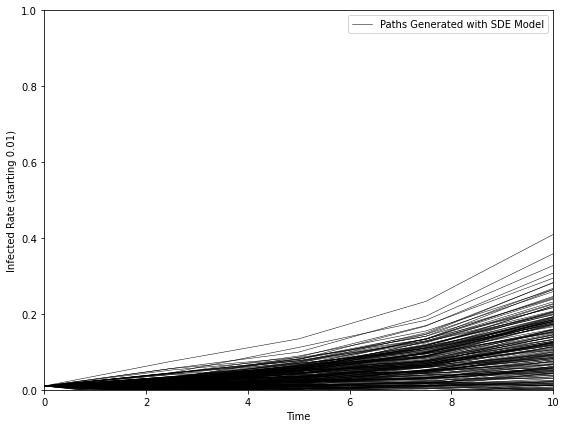

In [74]:
x_data,y_data,x_data_test,y_data_test = loadSIRInfo1D()
for i in range(1000):
    x_data_test[i] = 0.01
T_steps = 5
N_iterates = 250

rng = np.random.default_rng(random_seed)

time_steps, paths_network = \
    generate_results(sde_i.drift_diffusivity,
                     step_size, x_data_test, rng,
                     T_steps=T_steps, N_iterates=N_iterates);
plot_results_1d_generated(time_steps, paths_network, plot_dim=0, linewidth=0.5);
plt.gca().set_ylim([0,1])
plt.gca().set_xlim([0,10])

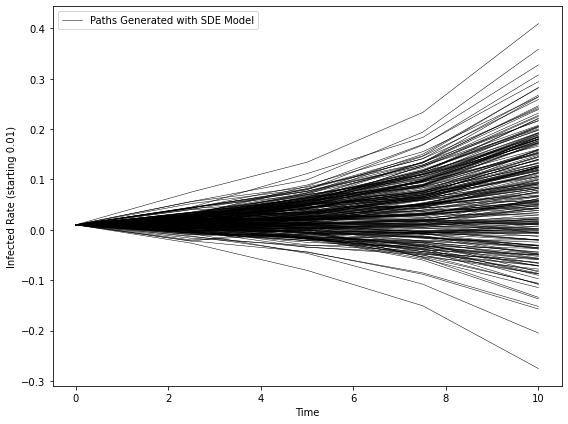

In [75]:
plot_results_1d_generated(time_steps, paths_network, plot_dim=0, linewidth=.5);

# True Path vs Generated Path Comparison

### Burda da x_data_test'imiz 0.01 den baslayacak hem generated hem true path icin. Sadece ilk gun verisini alip resultlari generate edecek. True Path ise Simulasyonun aynisi olacak. True path simulasyon datasi, generated path onun generated'i olacak.
### T_steps'i 5 verdik ki true path'deki time stepleriyle ayni olsun. 250 data point'den 1000 result generate etsin. 4 gun var cunku.

In [62]:
x_data,y_data,x_data_test,y_data_test = loadSIRInfo1D()
step_sizes = np.zeros((x_data.shape[0],)) + step_size

# True Path simulasyonun aynisi. 1.gunun basi - 1.gunun sonu - 2. gunun sonu - 3. - 4. [birinin sonu birinin basi cunku] 
true_path = []
for i in range(0, len(x_data_test), 4):
    path = np.array([x_data_test[i], x_data_test[i+1], x_data_test[i+2],x_data_test[i+3],y_data_test[i+3]])
    true_path.append(path)
for i in range(1000):
    x_data_test[i] = 0.01
x_data_test = x_data_test[:250]

In [63]:
from sde.sde_learning_network import \
(
    SDEIntegrators
)
def generate_results2(apx_drift_diffusivity,
                     step_size, x_data, rng, T_steps=25, N_iterates=10,                     
                     p_data=None):
    """
    x_data is used to sample initial conditions (N*p) matrix, with N initial conditions of dimension p.
    """

    def generate_path(f_sigma_, _x0, N, _p0=None):
        y_next = np.zeros((N, _x0.shape[1]))
        y_next[0, :] = _x0
        for k in range(1, N):
            _y_k = y_next[k - 1, :].reshape(1, -1)
            _p_k = _p0
            y_next[k, :] = SDEIntegrators.euler_maruyama(_y_k,
                                                         step_size,
                                                         f_sigma_,
                                                         rng,
                                                         param=_p_k)
        return y_next

    time_steps = [np.arange(T_steps) * step_size] * N_iterates
    paths_ = []

    p0 = None
    for k in range(N_iterates):
        #print(x_data[k])
        x0 = x_data[k].reshape(1, -1)
        path_ = generate_path(apx_drift_diffusivity, x0,
                              T_steps, _p0=p0)
        #print(path_)
        paths_.append(path_)

    return time_steps, paths_

        
        
# generate_results2 ile generate_results arasinda bir fark yok gibi.
time_steps, paths_network = generate_results2(sde_i.drift_diffusivity,
                     step_size, x_data_test, rng,
                     T_steps=5, N_iterates=250);

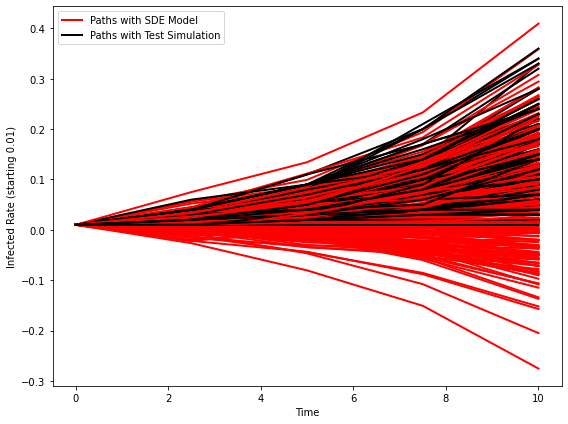

In [76]:

# Hicbir limit uygulanmamis true - generated path networks.
plot_results_1d(time_steps, paths_network,true_path, plot_dim=0, linewidth=2);

(0.0, 10.0)

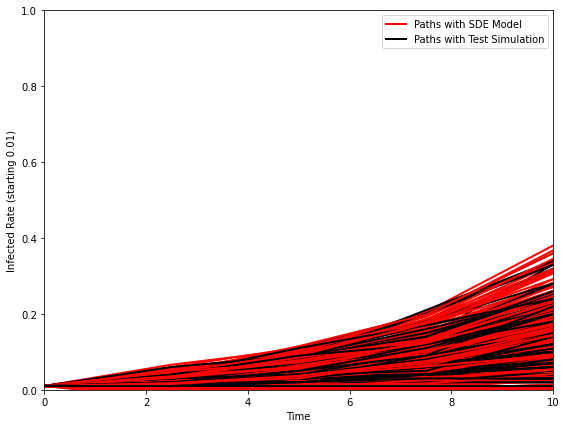

In [65]:

# maximum ve minimum infected rate'li (1.0 ve 0.0) sinirlandirmayla true vs network paths. Cunku model negatif veya 1.0'den fazla da verebiliyor. 
plot_results_1d(time_steps, paths_network,true_path, plot_dim=0, linewidth=2);
plt.gca().set_ylim([0,1])
plt.gca().set_xlim([0,10])

# Training Data Data Distribution Charts

In [66]:
x_data,y_data,x_data_test,y_data_test = loadSIRInfo1D()
input_data = np.concatenate((x_data, x_data_test), axis=None)
output_data = np.concatenate((y_data, y_data_test), axis=None)

# Infected Distribution

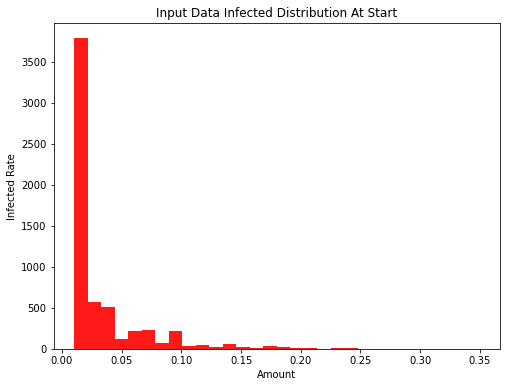

In [67]:
plot_distribution(input_data,xlabel="Amount",ylabel="Infected Rate",title="Input Data Infected Distribution At Start", figsize=(8, 6))

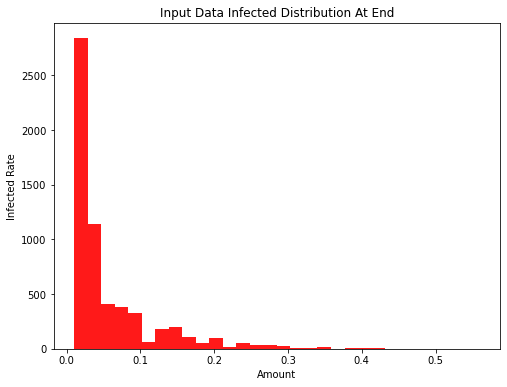

In [68]:
plot_distribution(output_data,xlabel="Amount",ylabel="Infected Rate",title="Input Data Infected Distribution At End", figsize=(8, 6),color='red')

# Susceptible Distribution

In [69]:
round(1.0-input_data[0],2)

0.99

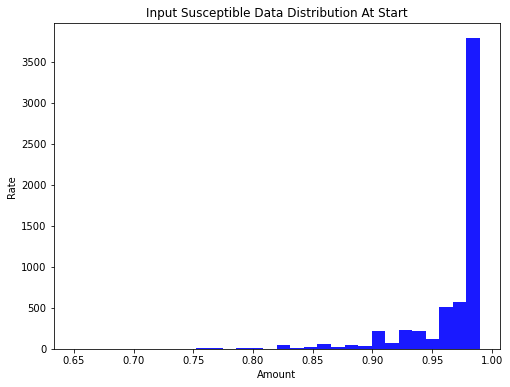

In [70]:
x_data,y_data,x_data_test,y_data_test = loadSIRInfo1D()
input_data = np.concatenate((x_data, x_data_test), axis=None)
output_data = np.concatenate((y_data, y_data_test), axis=None)

input_data_susceptible = input_data
output_data_susceptible = output_data

for i in range(len(input_data)):
    input_data_susceptible[i] = round(1.0-input_data[i],2)
    output_data_susceptible[i] = round(1.0-output_data[i],2)

plot_distribution(input_data_susceptible,xlabel="Amount",ylabel="Rate",title="Input Susceptible Data Distribution At Start", figsize=(8, 6),color='blue')

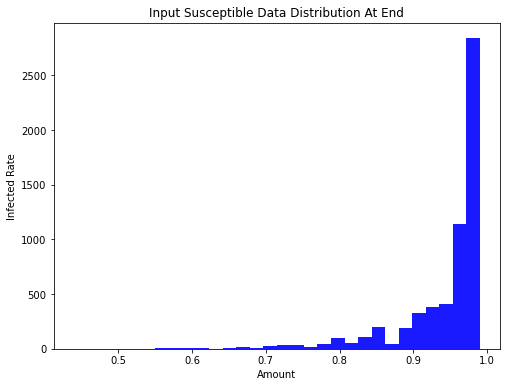

In [71]:
x_data,y_data,x_data_test,y_data_test = loadSIRInfo1D()
input_data = np.concatenate((x_data, x_data_test), axis=None)
output_data = np.concatenate((y_data, y_data_test), axis=None)

input_data_susceptible = input_data
output_data_susceptible = output_data

for i in range(len(input_data)):
    input_data_susceptible[i] = round(1.0-input_data[i],2)
    output_data_susceptible[i] = round(1.0-output_data[i],2)

plot_distribution(output_data_susceptible,xlabel="Amount",ylabel="Infected Rate",title="Input Susceptible Data Distribution At End", figsize=(8, 6),color='blue')